## Make neat plots for bachelor project with intial and optimal values for the models - Hydrogen-Crystal

## Importing everything we need

In [1]:
# Importing everthing we need 
import sys
sys.path.append('../')

from GAP.gapmodels import GAPModel
from GAP.gapmodels import Split
from GAP.gapdescriptors import distance_2b
from GAP.gapplot import QualityPlot
import matplotlib.pyplot as plt
from textwrap import wrap

## fixed parameters 

In [2]:
cutoff = [4]
n_sparse = [20]
delta = [1]
sparse_method = ['UNIFORM']
covariance_type = ['ARD_SE']
sigma_fixed = ['0.0 0.0'] # sigma for hessian and virial stress is not used and hence won't be optimized

## variable parameters

In [3]:
initial_guess = [1,0.008,0.04] 
opt_params_crystal = [0.38415538, 0.06524831, 0.05259016]
opt_params_h2 = [ 0.32570375,  0.00797225, 0.00935375]

## Split up the Data 

In [4]:
## Import Hydrogen_MD Data and split into training and test data, use split 80%/20%
data='/Users/simon/simon_ml/tools/hydrogencrystal.xyz'
train_percentage = 0.8
split = Split(data, train_percentage)

#Perform the acutal split
train_file = 'train.xyz'
test_file = 'test.xyz'
split.split(train_file, test_file)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ase/io/extxyz.py:997: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ase/io/extxyz.py:997: UserWarning: write_xyz() overwriting array "energies" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


## Test to figure out nice figure seetings

In [5]:
def RMSE_plot_energy(theta,sigma_energy,sigma_force,title):
    data_file = 'train.xyz'
    validation_file = 'test.xyz'
    # Initialize all parameters, fixed and variable
    cutoff = 4
    n_sparse = 20
    delta = 1
    sparse_method = 'UNIFORM'
    covariance_type = 'ARD_SE'
    sigma_fixed = '0.0 0.0' # sigma for hessian and virial stress is not used and hence won't be optimized
    theta = theta
    sigma_energy = sigma_energy
    sigma_force = sigma_force
    sigma = f"{sigma_energy} {sigma_force} {sigma_fixed}"
    descriptor_2b = distance_2b(cutoff=cutoff, covariance_type=covariance_type,delta=delta,theta_uniform=theta,
                                n_sparse=n_sparse, sparse_method=sparse_method,add_species='T')
    
    # Get parameter string
    parameters = descriptor_2b.get_parameter_string()
    
    # Make model
    model = GAPModel()

    # Select filename in which potential should be stored 
    potential=f"GAP.xml"

     # Train model
    model.train(parameters, training_data=data_file,GAP_potential=potential,sigma=sigma,print_output=False)

    # Select filename in which predictions should be stored for prediction data
    prediction_file_tr= f"quip_2btrain.xyz"
    prediction_file_val= f"quip_2bvalidate.xyz"

    # Predict energies on training data
    model.predict(Test_Data=data_file, GAP_potential=potential, QUIP_Prediction=prediction_file_tr,print_output=False)
    
    # Predict energies on validation data
    model.predict(Test_Data=validation_file, GAP_potential=potential, QUIP_Prediction=prediction_file_val,print_output=False)
    
    # Calculate RMSE of error, forces are scaled by 576 (number of forces per timestep: 192 atoms, 
    #3 spacial coordiantes) energies are scaled by factor 10^2 because energy scale is that much 
    # smaller then force scale
    rmse_energy_train = model.energy_RMSE(data_file,prediction_file_tr) /192
    rmse_force_train = model.force_RMSE(data_file,prediction_file_tr) / 576
    rmse_energy_validate = model.energy_RMSE(validation_file,prediction_file_val) /192
    rmse_force_validate = model.force_RMSE(validation_file,prediction_file_val) /576
    
    RMSE = rmse_energy_train + rmse_force_train + rmse_energy_validate + rmse_force_validate

    # Make Plot 
    plot = QualityPlot()
    # Make subplots object, returning axis object which is going to be passed to QualityPlot
    figs, axs = plt.subplots(nrows=1,ncols=2,gridspec_kw={'wspace':1,'hspace':1})
    
    # Plot predicted energies of training data against real energies of training data
    plot.energies_on_energies(real_values=data_file, predicted_values=prediction_file_tr, 
                            axis=axs[0],
                            title="")
    #plot.forces_on_forces(real_values=data_file, predicted_values=prediction_file_tr, 
                        #axis=axs[0,1],
                        #title="\n".join(wrap(f"Force of Training Data "
                        #f"theta_uniform = {theta}, sigma_force = {sigma_force}",20)))
    
    plot.energies_on_energies(real_values=validation_file, predicted_values=prediction_file_val, 
                            axis=axs[1],
                            title="")
    #plot.forces_on_forces(real_values=validation_file, predicted_values=prediction_file_val, 
                        #axis=axs[1,1],
                        #title="\n".join(wrap(f"Force of Validation Data "
                        #f"theta_uniform = {theta}, sigma_force = {sigma_force}",20)))
    from matplotlib.backends.backend_pdf import PdfPages
    with PdfPages(f"{title}.pdf") as pdf:
        pdf.savefig(bbox_inches = "tight")
    return RMSE

In [6]:
def RMSE_plot_force(theta,sigma_energy,sigma_force,title):
    data_file = 'train.xyz'
    validation_file = 'test.xyz'
    # Initialize all parameters, fixed and variable
    cutoff = 4
    n_sparse = 20
    delta = 1
    sparse_method = 'UNIFORM'
    covariance_type = 'ARD_SE'
    sigma_fixed = '0.0 0.0' # sigma for hessian and virial stress is not used and hence won't be optimized
    theta = theta
    sigma_energy = sigma_energy
    sigma_force = sigma_force
    sigma = f"{sigma_energy} {sigma_force} {sigma_fixed}"
    descriptor_2b = distance_2b(cutoff=cutoff, covariance_type=covariance_type,delta=delta,theta_uniform=theta,
                                n_sparse=n_sparse, sparse_method=sparse_method,add_species='T')
    
    # Get parameter string
    parameters = descriptor_2b.get_parameter_string()
    
    # Make model
    model = GAPModel()

    # Select filename in which potential should be stored 
    potential=f"GAP.xml"

     # Train model
    model.train(parameters, training_data=data_file,GAP_potential=potential,sigma=sigma,print_output=False)

    # Select filename in which predictions should be stored for prediction data
    prediction_file_tr= f"quip_2btrain.xyz"
    prediction_file_val= f"quip_2bvalidate.xyz"

    # Predict energies on training data
    model.predict(Test_Data=data_file, GAP_potential=potential, QUIP_Prediction=prediction_file_tr,print_output=False)
    
    # Predict energies on validation data
    model.predict(Test_Data=validation_file, GAP_potential=potential, QUIP_Prediction=prediction_file_val,print_output=True)
    
    # Calculate RMSE of error, forces are scaled by 576 (number of forces per timestep: 192 atoms, 
    #3 spacial coordiantes) energies are scaled by factor 10^2 because energy scale is that much 
    # smaller then force scale
    rmse_energy_train = model.energy_RMSE(data_file,prediction_file_tr) /192
    rmse_force_train = model.force_RMSE(data_file,prediction_file_tr) / 576
    rmse_energy_validate = model.energy_RMSE(validation_file,prediction_file_val) /192
    rmse_force_validate = model.force_RMSE(validation_file,prediction_file_val) /576
    
    RMSE = rmse_energy_train + rmse_force_train + rmse_energy_validate + rmse_force_validate

    # Make Plot 
    plot = QualityPlot()
    # Make subplots object, returning axis object which is going to be passed to QualityPlot
    figs, axs = plt.subplots(nrows=1,ncols=2,gridspec_kw={'wspace':1,'hspace':1})
    
    # Plot predicted energies of training data against real energies of training data
    #plot.energies_on_energies(real_values=data_file, predicted_values=prediction_file_tr, 
                            #axis=axs[0],
                            #title="\n".join(wrap(f"Energy of Training Data  "
                            #f"Theta-Uniform = {theta},              Sigma-Energy = {sigma_energy},       Sigma-Force = {sigma_force}",30)))
    
    plot.forces_on_forces(real_values=data_file, predicted_values=prediction_file_tr, 
                        axis=axs[0],
                       title="")
    #plot.energies_on_energies(real_values=validation_file, predicted_values=prediction_file_val, 
                            #axis=axs[1],
                            #title="\n".join(wrap(f"Energy of Validation Data "
                            #f"Theta-Uniform = {theta} ,      Sigma-Energy = {sigma_energy},      Sigma-Force = {sigma_force}",30)))
    
    plot.forces_on_forces(real_values=validation_file, predicted_values=prediction_file_val, 
                        axis=axs[1],
                       title="")
    from matplotlib.backends.backend_pdf import PdfPages
    with PdfPages(f"{title}.pdf") as pdf:
        pdf.savefig(bbox_inches = "tight")
    return RMSE

## Plot Energies of Hydrogen Crystal

 distance_2b cutoff = 4 covariance_type = ARD_SE delta = 1 theta_uniform = 1 sparse_method = UNIFORM add_species = T n_sparse = 20


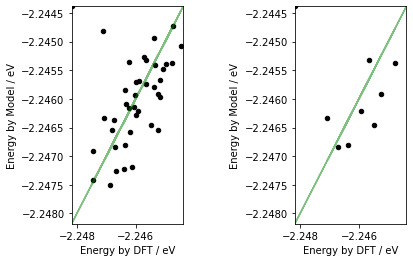

In [7]:
initial_guess= [1,0.008,0.04] 
RMSE_init = RMSE_plot_energy(initial_guess[0],initial_guess[1],initial_guess[2],title=f"Initial_Energies_HCrystal_notitle")

 distance_2b cutoff = 4 covariance_type = ARD_SE delta = 1 theta_uniform = 0.38415538 sparse_method = UNIFORM add_species = T n_sparse = 20


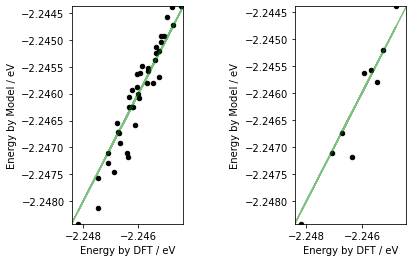

In [8]:
opt_params_crystal = [0.38415538, 0.06524831, 0.05259016]
RMSE_opt = RMSE_plot_energy(opt_params_crystal[0],opt_params_crystal[1],opt_params_crystal[2],title=f"Opt_Energies_HCrystal_notitle")

## Plot Forces of Hydrogen Crystal

 distance_2b cutoff = 4 covariance_type = ARD_SE delta = 1 theta_uniform = 1.0 sparse_method = UNIFORM add_species = T n_sparse = 20
 quip E=T F=T  atoms_filename='test.xyz'  param_filename='GAP.xml' | grep AT | sed 's/AT//'  > quip_2bvalidate.xyz 



0.0007362762793700782

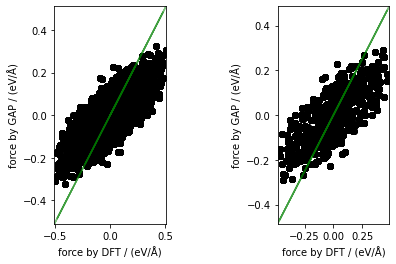

In [9]:
initial_guess = [1.000000,0.00800000,0.04000000] 
RMSE_init = RMSE_plot_force(initial_guess[0],initial_guess[1],initial_guess[2],title=f"Initial_Forces_HCrystal_notitle")
RMSE_init 

 distance_2b cutoff = 4 covariance_type = ARD_SE delta = 1 theta_uniform = 0.38415538 sparse_method = UNIFORM add_species = T n_sparse = 20
 quip E=T F=T  atoms_filename='test.xyz'  param_filename='GAP.xml' | grep AT | sed 's/AT//'  > quip_2bvalidate.xyz 



0.0002728588929043474

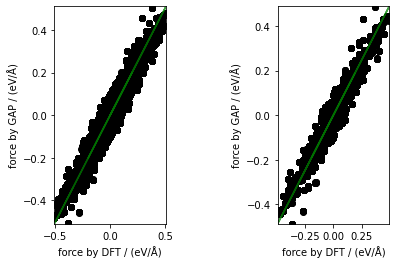

In [10]:
opt_params_crystal = [0.38415538, 0.06524831, 0.05259016]
RMSE_opt = RMSE_plot_force(opt_params_crystal[0],opt_params_crystal[1],opt_params_crystal[2],title=f"Opt_Forces_HCrystal_notitle")
RMSE_opt